In [12]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

data = pd.read_csv("D:/Rajib/Final.csv")
X = data.drop('Target', axis=1)
y = data['Target']

# Define test sizes and corresponding labels
test_sizes = [0.3, 0.2]
labels = ['70:30', '80:20']

# Initialize base classifiers including SVM and Naive Bayes
classifiers = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('ab', AdaBoostClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('svm', SVC(C=0.01, kernel='rbf', gamma='scale', probability=True, random_state=42)),  
    ('nb', GaussianNB())
]

# Initialize Stacking Classifier with individual classifiers
stacking_clf = StackingClassifier(
    estimators=classifiers,
    final_estimator=LogisticRegression()
)

# Parameters grid for RandomizedSearchCV
params = {
    'final_estimator__C': np.logspace(-4, 4, 10)
}

# DataFrame to store the results and metrics
results_list = []
metrics_list = []
accuracy_list = []

for i, size in enumerate(test_sizes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    partition = labels[i]
    
    # Evaluate each base classifier
    for name, clf in classifiers:
        start_time = time.time()
        clf.fit(X_train, y_train)
        end_time = time.time()
        train_time = end_time - start_time
        
        start_time = time.time()
        y_pred = clf.predict(X_test)
        end_time = time.time()
        test_time = end_time - start_time
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        accuracy = accuracy_score(y_test, y_pred)
        tpr = tp / (tp + fn)
        fnr = fn / (tp + fn)
        tnr = tn / (tn + fp)
        fpr = fp / (tn + fp)
        
        results_list.append({'Partition': partition, 'Classifier': name, 'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp})
        metrics_list.append({'Partition': partition, 'Classifier': name, 'TPR': tpr, 'FNR': fnr, 'TNR': tnr, 'FPR': fpr, 'Train Time': train_time, 'Test Time': test_time})
        accuracy_list.append({'Partition': partition, 'Classifier': name, 'Accuracy': accuracy})
    
    # Evaluate the Stacking Classifier
    start_time = time.time()
    random_search = RandomizedSearchCV(estimator=stacking_clf, param_distributions=params, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    start_time = time.time()
    best_clf = random_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    end_time = time.time()
    test_time = end_time - start_time
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_test, y_pred)
    tpr = tp / (tp + fn)
    fnr = fn / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (tn + fp)
    
    results_list.append({'Partition': partition, 'Classifier': 'Stacking', 'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp})
    metrics_list.append({'Partition': partition, 'Classifier': 'Stacking', 'TPR': tpr, 'FNR': fnr, 'TNR': tnr, 'FPR': fpr, 'Train Time': train_time, 'Test Time': test_time})
    accuracy_list.append({'Partition': partition, 'Classifier': 'Stacking', 'Accuracy': accuracy})

# Convert lists to DataFrames
results_df = pd.DataFrame(results_list)
metrics_df = pd.DataFrame(metrics_list)
accuracy_df = pd.DataFrame(accuracy_list)


In [13]:
# Display the performance metrics table
results_df

,Partition,Classifier,TP,FN,TN,FP
0,70:30,rf,62,1,108,0
1,70:30,gb,62,1,106,2
2,70:30,ab,62,1,105,3
3,70:30,xgb,61,2,106,2
4,70:30,svm,23,40,108,0
5,70:30,nb,62,1,106,2
6,70:30,Stacking,62,1,106,2
7,80:20,rf,42,1,71,0
8,80:20,gb,42,1,71,0
9,80:20,ab,42,1,70,1


In [14]:
# Display the detailed metrics table
metrics_df

,Partition,Classifier,TPR,FNR,TNR,FPR,Train Time,Test Time
0,70:30,rf,0.984127,0.015873,1.000000,0.000000,0.122000,0.008002
1,70:30,gb,0.984127,0.015873,0.981481,0.018519,0.157399,0.001000
2,70:30,ab,0.984127,0.015873,0.972222,0.027778,0.067415,0.000000
3,70:30,xgb,0.968254,0.031746,0.981481,0.018519,0.030130,0.000000
4,70:30,svm,0.365079,0.634921,1.000000,0.000000,0.031252,0.015626
5,70:30,nb,0.984127,0.015873,0.981481,0.018519,0.000000,0.000000
6,70:30,Stacking,0.984127,0.015873,0.981481,0.018519,18.870559,0.015689
7,80:20,rf,0.976744,0.023256,1.000000,0.000000,0.144609,0.015693
8,80:20,gb,0.976744,0.023256,1.000000,0.000000,0.175341,0.000000
9,80:20,ab,0.976744,0.023256,0.985915,0.014085,0.066284,0.015650


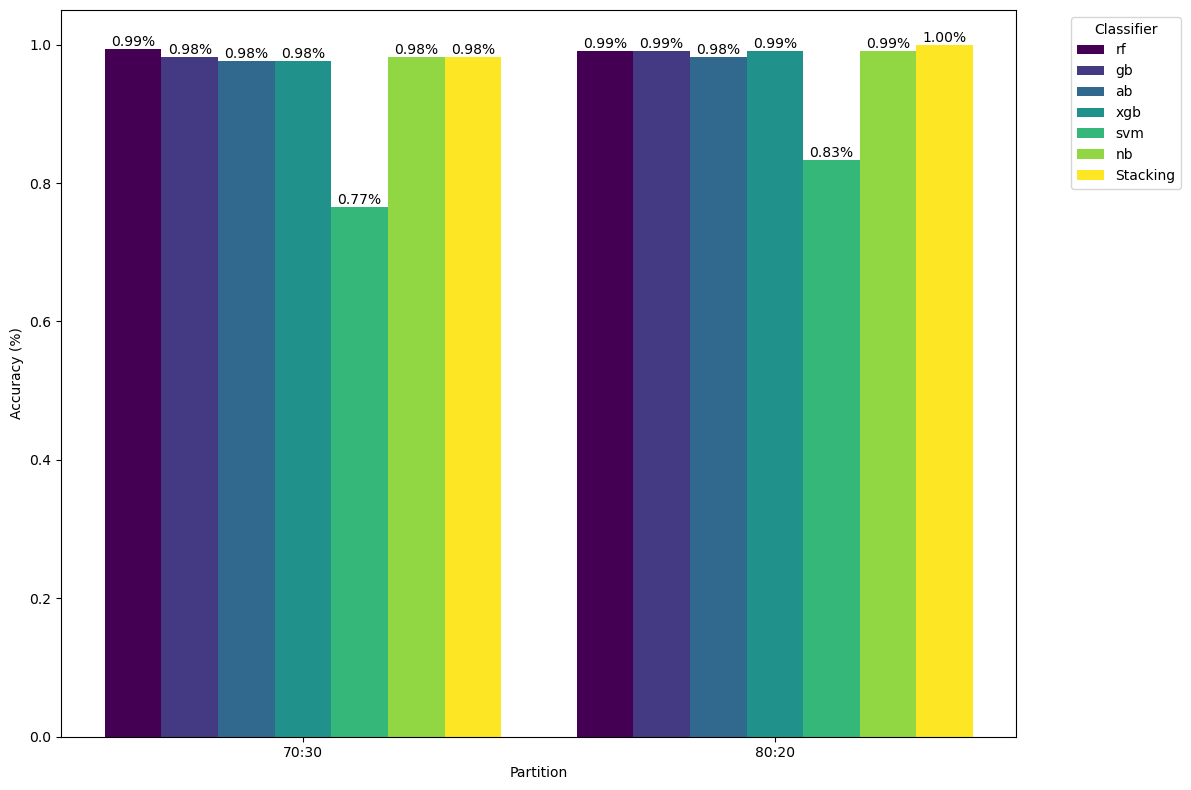

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'accuracy_df' is populated from the execution of your model evaluation
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.12  # Bar width for better fit with the addition of stacking
indices = np.arange(len(test_sizes))  # x locations for the groups

# Colors for each classifier, with one additional for the stacking classifier
colors = plt.cm.viridis(np.linspace(0, 1, len(classifiers) + 1))  # plus one for stacking

# Plot each classifier's accuracy
for i, (name, _) in enumerate(classifiers + [('Stacking', None)]):  # Include stacking classifier explicitly
    accuracies = accuracy_df[accuracy_df['Classifier'] == name]['Accuracy']
    bars = ax.bar(indices + i * width, accuracies, width, label=name, color=colors[i])

    # Label the bars with accuracy percentage
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

# Adding aesthetic elements to the plot
ax.set_xlabel('Partition')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(indices + width * (len(classifiers) / 2))  # Center the ticks between the groups
ax.set_xticklabels(labels)

# Place a legend outside of the plot area
ax.legend(title="Classifier", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


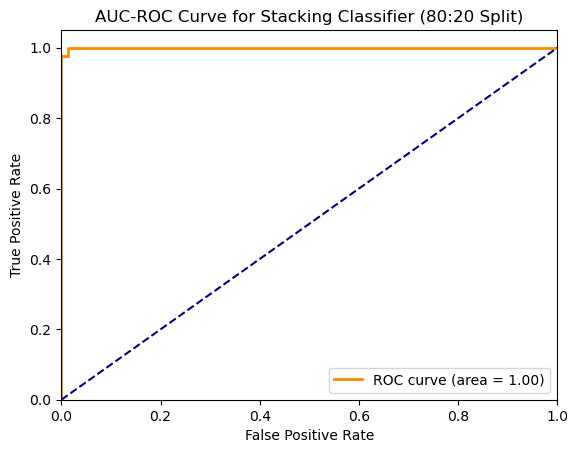

In [16]:
# Generate AUC-ROC Curve for the Stacking Classifier for the 80:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Ensure using 80:20 split data
stacking_clf.fit(X_train, y_train)
if hasattr(stacking_clf, "predict_proba"):
    probas_ = stacking_clf.predict_proba(X_test)[:, 1]
else:  # use decision function if predict_proba is not available
    probas_ = stacking_clf.decision_function(X_test)
    probas_ = (probas_ - probas_.min()) / (probas_.max() - probas_.min())  # Scale to [0,1]

fpr, tpr, thresholds = roc_curve(y_test, probas_)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve for Stacking Classifier (80:20 Split)')
plt.legend(loc="lower right")
plt.show()